## Set up paths and imports

In [1]:
import os
if not os.path.exists("./notebooks"):
    %cd ..

RESULTS_DIR = os.path.join("results", "algorithm_correctness")
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from src.log_reg_ccd import LogRegCCD
from src.data.data_loader import SyntheticDataLoader
from src.data.dataset_interface import DataInterface

SEED=1401

/home/mytkom/Documents/DataScience/AML/Projects/LogRegCCD


### Prepare synthetic dataset
Generate it, split it and standardize it for train split.

In [2]:
np.random.seed(SEED)
di = DataInterface(SyntheticDataLoader(p=0.5, n=1500, d=5, g=0))
di.split_data()
data = di.get_data()
print(data.keys())
X_train, y_train = data['train_data'], data['train_labels']
X_test, y_test = data['test_data'], data['test_labels']
X_valid, y_valid = data['val_data'], data['val_labels']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


dict_keys(['train_data', 'test_data', 'val_data', 'train_labels', 'test_labels', 'val_labels'])


### Test accuracy on the test split and test validate method on the valid split

Test accuracy: 0.7167
Best beta: [0.07967377 1.06481978 0.355444   0.26812623 0.08365316 0.24211571]


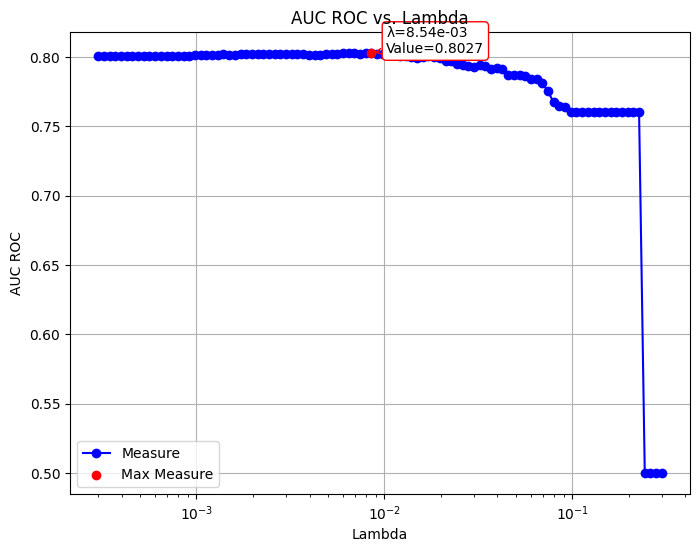

Test accuracy after validation: 0.7250
Best beta: [0.081591   1.14343175 0.41038652 0.31594155 0.12860983 0.29052292]


In [3]:
import src.measures as measure

model = LogRegCCD(verbose=False)
model.fit(X_train, y_train, lam_max=0.3, lam_count=100, k_fold=10)
lambdas = model.lambdas

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {accuracy:.4f}")
print(f"Best beta: {model.best_beta}")

model.plot(X_valid, y_valid, measure=measure.AUCROC())

model.validate(X_valid, y_valid, measure=measure.AUCROC())
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Test accuracy after validation: {accuracy:.4f}")
print(f"Best beta: {model.best_beta}")

### Plot and save regularization paths for `LogRegCCD` and `LogisticRegression`

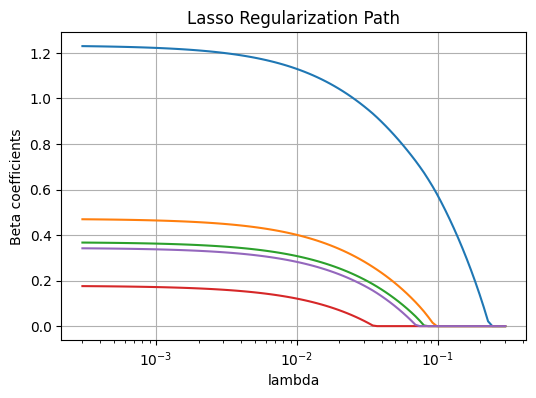

In [4]:
model.plot_lasso_path(path=os.path.join(RESULTS_DIR, "LogRegCCD-regularization-path.pdf"), figsize=(6,4))

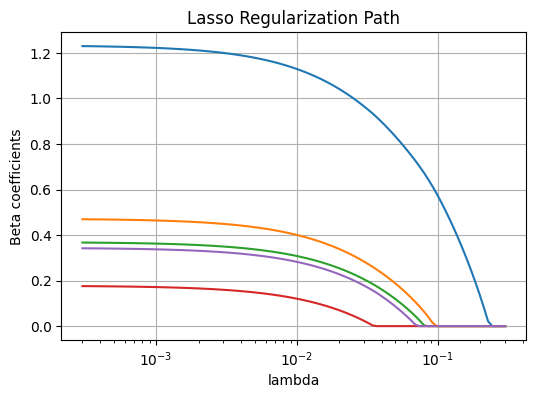

In [5]:

def plot_lasso_path(lambdas, betas, path: None | str = None):
        plt.figure(figsize=(6, 4))
        for i in range(0, betas.shape[1]):
            plt.plot(lambdas, betas[:, i], label=f'{i+1}')
        
        plt.xscale("log")
        plt.xlabel('lambda')
        plt.ylabel('Beta coefficients')
        plt.title('Lasso Regularization Path')
        plt.grid(True)
        if path is not None:
             plt.savefig(path)
        plt.show()

coefficients = []

for lam in lambdas:
    # different lambda scaling because of loss function definition
    model = LogisticRegression(C=1/(lam * X_train.shape[0]), penalty='l1', solver='liblinear', max_iter=10000)
    model.fit(X_train, y_train)
    coefficients.append(model.coef_.flatten())

coefficients = np.array(coefficients)

plot_lasso_path(lambdas, coefficients, os.path.join(RESULTS_DIR, "sklearn-LogisticRegression-regularization-path.pdf"))

### Compare `LogRegCCD` with $\lambda=0$ to `LogisticRegression` without penalty
Plot and save coefficients and accuracies on the test split.

                Model  Accuracy
0  LogisticRegression  0.713333
1           LogRegCCD  0.713333


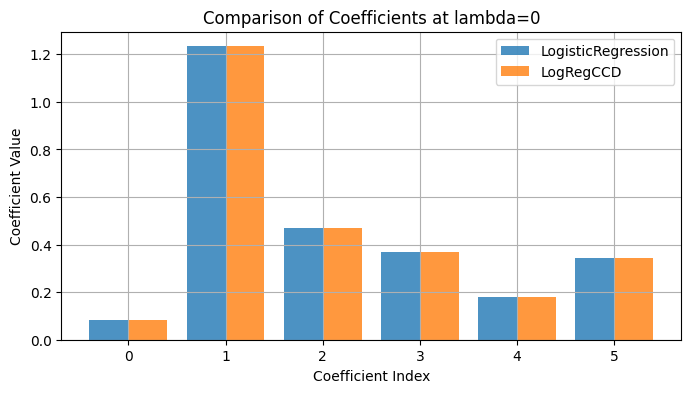

In [6]:
# LogisticRegression
model_sklearn = LogisticRegression(penalty=None)
model_sklearn.fit(X_train, y_train)

y_pred_sklearn = model_sklearn.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
beta_sklearn = np.array([*model_sklearn.intercept_, *model_sklearn.coef_[0]])

# LogRegCCD
model_ccd = LogRegCCD(verbose=False)
model_ccd.fit(X_train, y_train, lam_max=0, lam_count=1)

y_pred_ccd = model_ccd.predict(X_test)
accuracy_ccd = accuracy_score(y_test, y_pred_ccd)
beta_ccd = model_ccd.best_beta

# Accuracies
df_accuracy = pd.DataFrame({
    "Model": ["LogisticRegression", "LogRegCCD"],
    "Accuracy": [accuracy_sklearn, accuracy_ccd]
})
df_accuracy.to_csv(os.path.join(RESULTS_DIR, "accuracy_lambda_0.csv"), index=False)
print(df_accuracy)

# Plot coefficients
indices = np.arange(len(beta_sklearn))
width = 0.4

plt.figure(figsize=(8, 4))
plt.bar(indices - width/2, beta_sklearn, width=width, label="LogisticRegression", alpha=0.8)
plt.bar(indices + width/2, beta_ccd, width=width, label="LogRegCCD", alpha=0.8)

plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Value")
plt.title("Comparison of Coefficients at lambda=0")
plt.legend()
plt.grid()
plt.savefig(os.path.join(RESULTS_DIR, "coefficients_comparison_lambda_0.pdf"))
plt.show()